In [1]:
!git clone https://github.com/adanvga/imgs.git

Cloning into 'imgs'...
remote: Enumerating objects: 83942, done.
remote: Total 83942 (delta 0), reused 0 (delta 0), pack-reused 83942 (from 4)
Receiving objects: 100% (83942/83942), 4.26 GiB | 54.96 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (3008/3008), done.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'             # Silencia INFO y WARNING
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'            # Desactiva oneDNN

import cv2
import sys
import math
import random
import ntpath
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [3]:
datadir = 'imgs'
columns = ['center', 'left', 'right', 'steering', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
fila = data.iloc[[0]]
data.head()

,center,left,right,steering,speed
0,IMG/2025-06-22_20-57-23-227_bc.png,IMG/2025-06-22_20-57-23-227_al.png,IMG/2025-06-22_20-57-23-227_cr.png,-0.090090,28171.544327
1,IMG/2025-06-22_20-57-24-364_bc.png,IMG/2025-06-22_20-57-24-364_al.png,IMG/2025-06-22_20-57-24-364_cr.png,-0.083655,0.287426
2,IMG/2025-06-22_20-57-24-536_bc.png,IMG/2025-06-22_20-57-24-536_al.png,IMG/2025-06-22_20-57-24-536_cr.png,-0.106560,1.697294
3,IMG/2025-06-22_20-57-24-709_bc.png,IMG/2025-06-22_20-57-24-709_al.png,IMG/2025-06-22_20-57-24-709_cr.png,-0.090675,3.545730
4,IMG/2025-06-22_20-57-24-882_bc.png,IMG/2025-06-22_20-57-24-882_al.png,IMG/2025-06-22_20-57-24-882_cr.png,-0.092835,5.838656


In [4]:
import cv2
import numpy as np


# recibe una imagen RGB necesariamente
def img_preprocess(image):
    h, w = image.shape[:2]
    # Res: 120x300
    # 55% -> 66 px
    # 66.9% -> 200 px
    crop_h_start = int(h * 0.6) # 55% vertical
    crop_w = int(w * 1)       # 67% horizontal
    crop_w_start = (w - crop_w) // 2
    image = image[h-crop_h_start:, crop_w_start:crop_w_start + crop_w]
    #image = cv2.Canny(image, 75, 150)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.GaussianBlur(image,(3,3),0)
    image = cv2.resize(image, (200, 66))
    return image.astype(np.float32) / 255.0

def predecir_angulo(imagen, modelo):
    img_prep = img_preprocess(imagen)
    img_prep = np.expand_dims(img_prep, axis=0)
    try:
        angulo = modelo.predict(img_prep, verbose=0)[0][0]
        return angulo
    except Exception as e:
        print(f"[ERROR] model.predict: {e}")
        return float('inf')

def impath_predecir_angulo(ruta_imagen, modelo):
    img_bgr = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return predecir_angulo(img_rgb,modelo)



Total de timestamps original: 1002
Removed by bin balancing: 357
Final dataset size: 645

Refuerzo dinámico aplicado por bin. Tamaño final: 1948 muestras
Training Samples: 1558 | Validation Samples: 390



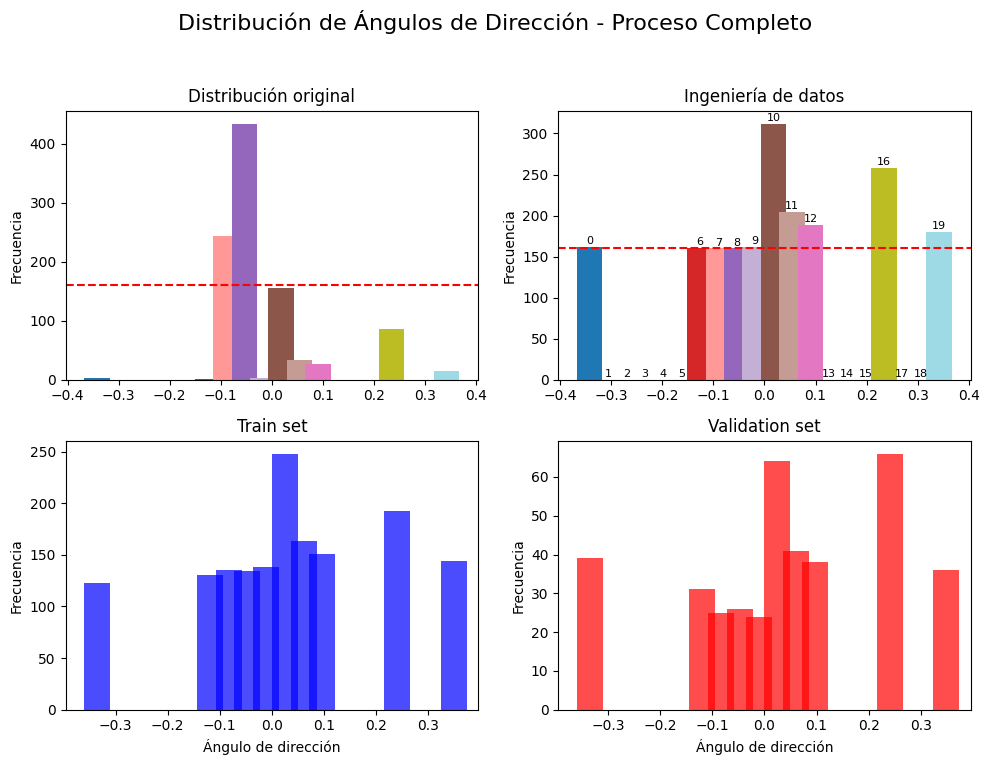

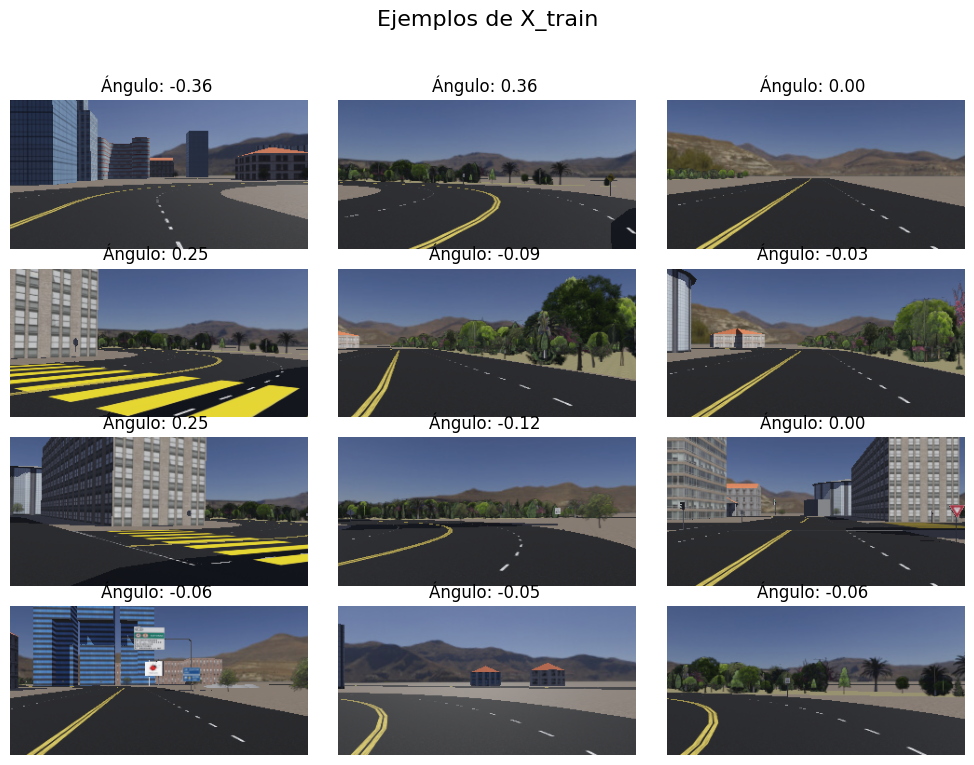

Shape del batch de ejemplo: (40, 66, 200, 3)
Shape de imagen: (66, 200, 3)



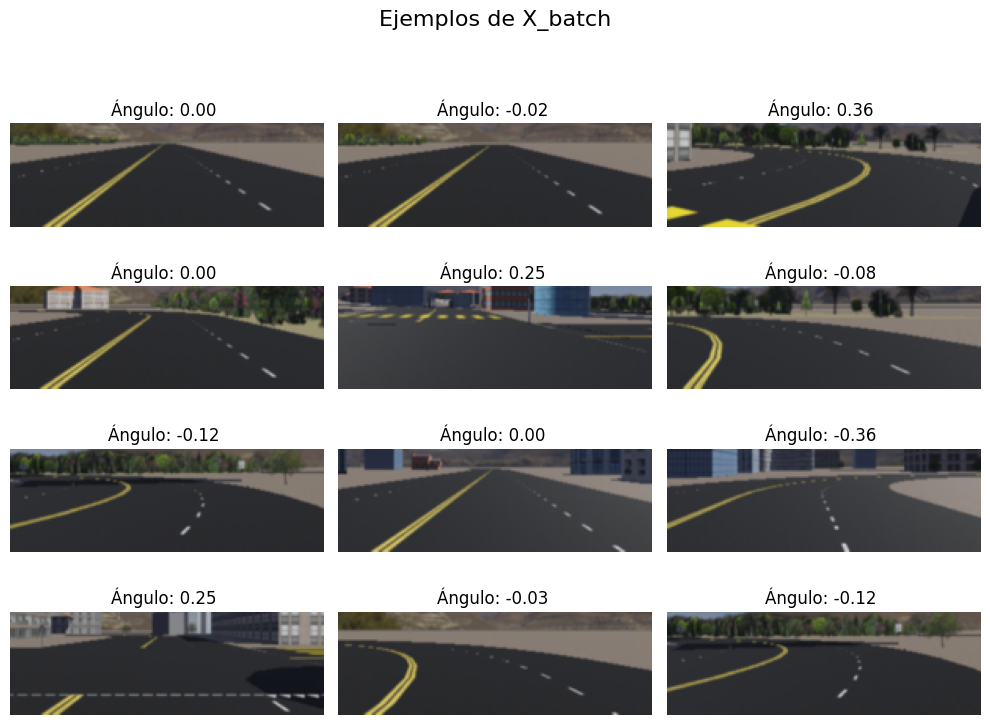

In [6]:

num_bins = 20
samples_per_bin = 160

are_we_training = True
balancear_datos = True
reforzar_bins = False
multiplicadores_por_bin = {
     2: 4,
     4:18,
     5: 5,
     6: 4,
     7: 3,
     8: 7,
     9:40,
    10:110,
    11:110,
    12:110,
    13:300,
    14:200,
    15:400,
    19: 2,
}
igualar_bins = True

incluir_izquierda_derecha = False
izq_der_offset = 0.25

train_adam_lr = 0.00005
train_epochs = 30
train_batch_size = 60*(3 if incluir_izquierda_derecha else 1 )
valdt_batch_size = 32

name_results    = r"model_performance.png"
name_data_eng   = r"model_data.png"
name_best_model = r"model_best.keras"
name_regl_model = r"model_nvidia.keras"

if are_we_training:
    for archivo in [name_results, name_best_model, name_regl_model]:
        if os.path.exists(archivo):
            os.remove(archivo)
            print(f"🗑️ Archivo eliminado: {archivo}")

datadir = r"imgs"
columns = ['center', 'left', 'right', 'steering', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
usando = 'steering'

hist_orig, bins_orig = np.histogram(data[usando], num_bins)
center_orig = (bins_orig[:-1] + bins_orig[1:]) * 0.5
# ---------- Paso 1: Balancear (recortar predominancia de rectas) ----------
def imprimir_datos_bins():
    # Calcular histogram bins
    hist, bins = np.histogram(data[usando], num_bins)

    # Para cada bin, obtener las muestras y su promedio
    print(f"{'Bin':>3} | {'Rango':>20} | {'Muestras':>9} | {'Ángulo promedio':>18} | {'Std dev':>8}")
    print("-" * 70)

    for i in range(num_bins):
        bin_min = bins[i]
        bin_max = bins[i+1]

        # Filtrar los valores que caen en el bin
        bin_vals = data[(data[usando] >= bin_min) & (data[usando] < bin_max)][usando]

        if len(bin_vals) > 0:
            avg = bin_vals.mean()
            std = bin_vals.std()
            print(f"{i:>3} | [{bin_min:+.4f}, {bin_max:+.4f}) | {len(bin_vals):>9} | {avg:>18.5f} | {std:>8.5f}")
        else:
            print(f"{i:>3} | [{bin_min:+.4f}, {bin_max:+.4f}) | {0:>9} | {'-':>18} | {'-':>8}")


if balancear_datos:
    remove_list = []
    hist, bins = np.histogram(data[usando], num_bins)

    for i in range(num_bins):
        bin_indices = []
        for j in range(len(data[usando])):
            val = float(data[usando].iloc[j])
            if bins[i] <= val <= bins[i+1]:
                bin_indices.append(j)
        bin_indices = shuffle(bin_indices)
        if len(bin_indices) > samples_per_bin:
            remove_list.extend(bin_indices[samples_per_bin:])

    len_after_bin_removal = len(data) - len(remove_list)
    original_len = len(data)
    indices_reales = data.iloc[remove_list].index
    data.drop(index=indices_reales, inplace=True)
    data.reset_index(drop=True, inplace=True)

    print("")
    print(f"Total de timestamps original: {original_len}")
    print(f"Removed by bin balancing: {original_len - len_after_bin_removal}")
    print(f"Final dataset size: {len(data)}")
    print("")

if reforzar_bins:
    reforzado = []
    hist, bins = np.histogram(data[usando], bins=num_bins)
    for i, fila in data.iterrows():
        angulo = fila[usando]
        bin_index = np.digitize(angulo, bins) - 1
        bin_index = max(0, min(bin_index, num_bins - 1))  # asegurar límites válidos
        multiplicador = multiplicadores_por_bin.get(bin_index, 1)
        reforzado.append(fila)
        for _ in range(multiplicador - 1):
            reforzado.append(fila.copy())
    data = pd.DataFrame(reforzado)


if igualar_bins:
    hist, bins = np.histogram(data[usando], num_bins)
    max_bin_count = np.max(hist)
    reforzado = []

    for b in range(num_bins):
        if b == num_bins - 1:
            bin_data = data[(data[usando] >= bins[b]) & (data[usando] <= bins[b + 1])]
        else:
            bin_data = data[(data[usando] >= bins[b]) & (data[usando] < bins[b + 1])]
        count_bin = len(bin_data)

        if count_bin == 0:
            continue

        if count_bin >= max_bin_count:
            continue  # ⚠️ ya está suficientemente representado

        mult = int(round(max_bin_count / count_bin))
        bin_reforzado = pd.concat([bin_data] * mult, ignore_index=True)
        reforzado.append(bin_reforzado)

    # Unimos el original con los duplicados de bins poco representados
    data = pd.concat([data] + reforzado, ignore_index=True)
    print(f"Refuerzo dinámico aplicado por bin. Tamaño final: {len(data)} muestras")

# Histograma después del filtrado
hist_filt, bins_filt = np.histogram(data[usando], num_bins)
center_filt = (bins_filt[:-1] + bins_filt[1:]) * 0.5

def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center = os.path.join(datadir, indexed_data['center'].strip())
        left = os.path.join(datadir, indexed_data['left'].strip())
        right = os.path.join(datadir, indexed_data['right'].strip())
        angle = float(indexed_data[usando])
        if os.path.exists(center) and os.path.exists(left) and os.path.exists(right):
            image_path.append(center)
            steering.append(angle)
            if incluir_izquierda_derecha:
                image_path.append(left)
                steering.append(angle + izq_der_offset)
                image_path.append(right)
                steering.append(angle - izq_der_offset)
    return np.asarray(image_path), np.asarray(steering)

image_paths, steerings = load_img_steering(datadir, data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples:', len(X_train), '| Validation Samples:', len(X_valid))
print("")

if balancear_datos or igualar_bins or reforzar_bins:
    cmap = plt.get_cmap('tab20')
    # Crear lista de colores para cada bin (usar el mismo número de bins que `center_orig`)
    colors_orig = [cmap(i % cmap.N) for i in range(len(center_orig))]
    colors_filt = [cmap(i % cmap.N) for i in range(len(center_filt))]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Distribución de Ángulos de Dirección - Proceso Completo", fontsize=16)

    # Gráfico 1: Distribución original (arriba izquierda)
    axes[0, 0].bar(center_orig, hist_orig, width=0.05,color=colors_orig)
    axes[0, 0].axhline(samples_per_bin, color='r', linestyle='--')
    axes[0, 0].set_title("Distribución original")
    axes[0, 0].set_ylabel("Frecuencia")

    # Gráfico 2: Después del filtrado (arriba derecha)
    axes[0, 1].bar(center_filt, hist_filt, width=0.05,color=colors_filt)
    axes[0, 1].axhline(samples_per_bin, color='r', linestyle='--')
    axes[0, 1].set_title("Ingeniería de datos")
    axes[0, 1].set_ylabel("Frecuencia")
    for idx, (x, h) in enumerate(zip(center_filt, hist_filt)):
        axes[0, 1].text(x, h + 1, str(idx), ha='center', va='bottom', fontsize=8,)


    # Gráfico 3: Train (abajo izquierda)
    axes[1, 0].hist(y_train, bins=num_bins, width=0.05, color='blue', alpha=0.7)
    axes[1, 0].set_title("Train set")
    axes[1, 0].set_xlabel("Ángulo de dirección")
    axes[1, 0].set_ylabel("Frecuencia")

    # Gráfico 4: Validation (abajo derecha)
    axes[1, 1].hist(y_valid, bins=num_bins, width=0.05, color='red', alpha=0.7)
    axes[1, 1].set_title("Validation set")
    axes[1, 1].set_xlabel("Ángulo de dirección")
    axes[1, 1].set_ylabel("Frecuencia")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título superior
    fig.savefig(f"{name_data_eng}", dpi=300)
    plt.show(block=False)
    plt.pause(0.1)


def show_samples(X,y,blocking=False,isPath=False,name=""):
  num_muestras = 12
  filas, columnas = 4, 3
  indices = np.random.choice(len(X), size=num_muestras, replace=False)
  plt.figure(figsize=(10, 8))
  title = "Ejemplos de X" if len(name)==0 else f"Ejemplos de {name}"
  plt.suptitle(title, fontsize=16)
  for i, idx in enumerate(indices):
      angle = y[idx]
      img = cv2.cvtColor(cv2.imread(X[idx]), cv2.COLOR_BGR2RGB) if isPath else (X[idx] * 255).astype(np.uint8)
      #img = (X[idx] * 255).astype(np.uint8)
      plt.subplot(filas, columnas, i + 1)
      plt.imshow(img)
      plt.title(f"Ángulo: {angle:.2f} ")
      plt.axis('off')
  #plt.tight_layout()
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show(block=blocking)
  plt.pause(0.1)

show_samples(X_train,y_train,isPath=True,name="X_train")

def batch_generator_seq(image_paths, steering_ang, batch_size):
    num_samples = len(image_paths)
    index = 0
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            if index >= num_samples:
                index = 0  # reinicio
            img = cv2.imread(image_paths[index])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img_preprocess(img)
            batch_img.append(img)
            batch_steering.append(steering_ang[index])
            index += 1
        yield (np.asarray(batch_img), np.asarray(batch_steering))

x_batch, y_batch = next(batch_generator_seq(X_train, y_train, batch_size=40))
print("Shape del batch de ejemplo:", x_batch.shape)
img_ejemplo = x_batch[0]
print("Shape de imagen:", img_ejemplo.shape)
print("")

show_samples(x_batch,y_batch,blocking=not(are_we_training),name="X_batch")

In [7]:

if not are_we_training:
    print("Evitamos el entrenamiento")
    #sys.exit("Evitamos el entrenamiento")
else:
    #model.add(Input(shape=(66, 200, 3)))  # Primera capa declarando la forma de entrada
    input_shape = img_ejemplo.shape  # (altura, ancho, canales)

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    model.compile(
        loss=Huber(delta=0.05),
        optimizer=Adam(learning_rate=train_adam_lr),
        metrics=[MeanAbsoluteError()]
        )

    # Mostrar resumen
    #model.summary()

In [8]:

    print("")
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    print("")

    checkpoint = ModelCheckpoint(name_best_model,monitor='val_loss',save_best_only=True,verbose=0)

    steps_per_epoch = math.ceil(len(X_train) / train_batch_size)
    validation_steps = max(1, math.ceil(len(X_valid) / valdt_batch_size))

    history = model.fit(
        batch_generator_seq(X_train, y_train, batch_size=train_batch_size),
        steps_per_epoch=steps_per_epoch,
        validation_data=batch_generator_seq(X_valid, y_valid, batch_size=valdt_batch_size),
        validation_steps=validation_steps,
        epochs=train_epochs,
        callbacks=[checkpoint],
        verbose=1
    )



Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - loss: 0.0058 - mean_absolute_error: 0.1384 - val_loss: 0.0036 - val_mean_absolute_error: 0.0928
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 0.0030 - mean_absolute_error: 0.0818 - val_loss: 0.0028 - val_mean_absolute_error: 0.0783
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.0020 - mean_absolute_error: 0.0605 - val_loss: 0.0015 - val_mean_absolute_error: 0.0481
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.0013 - mean_absolute_error: 0.0429 - val_loss: 0.0012 - val_mean_absolute_error: 0.0395
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 9.9945e-04 - mean_absolute_error: 0.0362 - val_loss: 0.0010 - val_mean_absolute_error: 0.0357
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 8.1793e-04 - mean_absolute_error: 0.0311 - val_loss: 8.9311e-04 - val_mean_absolute_error: 0.0325
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 6.9132e-04 - mean_absolut

Entrenamiento finalizado. Mejor modelo guardado

Modelo guardado



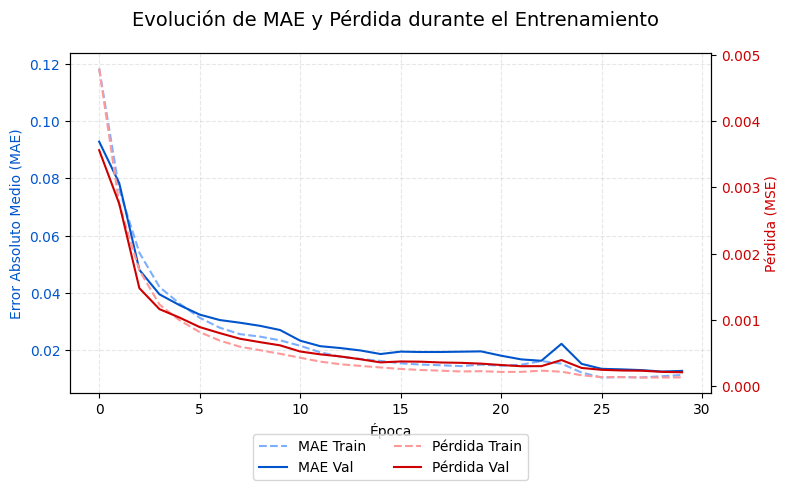

In [9]:

    print("Entrenamiento finalizado. Mejor modelo guardado")
    print("")
    model.save(name_regl_model)
    print("Modelo guardado")
    print("")

    fig, ax1 = plt.subplots(figsize=(8, 5))
    # Error Absoluto Medio - eje izquierdo
    lns1 = ax1.plot(history.history['mean_absolute_error'], label='MAE Train', color='#7dafff', linestyle='--')  # azul claro
    lns2 = ax1.plot(history.history['val_mean_absolute_error'], label='MAE Val', color='#0055cc', linestyle='-')  # azul fuerte
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Error Absoluto Medio (MAE)', color='#0055cc')
    ax1.tick_params(axis='y', labelcolor='#0055cc')
    ax1.grid(True, which='both', axis='both', linestyle='--', alpha=0.3)

    # Pérdida (MSE) - eje derecho
    ax2 = ax1.twinx()
    lns3 = ax2.plot(history.history['loss'], label='Pérdida Train', color='#ff9999', linestyle='--')  # rojo claro
    lns4 = ax2.plot(history.history['val_loss'], label='Pérdida Val', color='#cc0000', linestyle='-')  # rojo fuerte
    ax2.set_ylabel('Pérdida (MSE)', color='#cc0000')
    ax2.tick_params(axis='y', labelcolor='#cc0000')

    # Leyenda combinada
    lines = lns1 + lns2 + lns3 + lns4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    # Título
    fig.suptitle('Evolución de MAE y Pérdida durante el Entrenamiento', fontsize=14)
    plt.tight_layout()
    fig.savefig(f"{name_results}", dpi=300)
    plt.show(block=False)
    plt.pause(0.1)

In [11]:

mejor_modelo = load_model(name_best_model)
modelo = mejor_modelo
print("")
print("Mejor modelo cargado")
print("🔢 Total de parámetros     :", modelo.count_params())
print("🧠 Parámetros entrenables :", sum([K.count_params(w) for w in modelo.trainable_weights]))
print("🧊 Parámetros no entrenables:", sum([K.count_params(w) for w in modelo.non_trainable_weights]))

modelo_cargado = load_model(name_regl_model)
modelo = modelo_cargado
print("")
print("Modelo cargado")
print("🔢 Total de parámetros     :", modelo.count_params())
print("🧠 Parámetros entrenables :", sum([K.count_params(w) for w in modelo.trainable_weights]))
print("🧊 Parámetros no entrenables:", sum([K.count_params(w) for w in modelo.non_trainable_weights]))

if not are_we_training:
    sys.exit()



Mejor modelo cargado
🔢 Total de parámetros     : 252219
🧠 Parámetros entrenables : 252219
🧊 Parámetros no entrenables: 0

Modelo cargado
🔢 Total de parámetros     : 252219
🧠 Parámetros entrenables : 252219
🧊 Parámetros no entrenables: 0
